In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.metrics
import cv2
import pickle
import os, os.path
import importlib

import utils.sampletools as smpl

importlib.reload(smpl)

C:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<module 'utils.sampletools' from 'd:\\Programming\\NClassifier\\dev_tests\\tf01_cnn_detect\\utils\\sampletools.py'>

In [2]:
def generate_batches_from_image_sample(image, sample, size_chain, batch_size, shuffle=True):
    mipimgs = smpl.generate_image_miplevels(image, size_chain, resize_function=lambda x, s:cv2.resize(x, dsize=(s[0], s[1])))
    for s in smpl.shuffle_batches(sample, batch_size=batch_size, shuffle=shuffle):
        features = smpl.extract_features_from_samples_and_mipmaps(s, mipimgs)
        targets = smpl.extract_targets_from_samples(s)
        yield (features, targets)
        
def generate_batches_from_file(path, fname, batch_size, shuffle=True):
    with open(os.path.join(path,fname), 'rb') as f:
        sample, size_chain, img_fname = pickle.load(f)
    image = cv2.cvtColor(cv2.imread(os.path.join(path,img_fname)), cv2.COLOR_BGR2RGB)
    for s in generate_batches_from_image_sample(image, sample, size_chain, batch_size, shuffle=shuffle):
        yield s
        
def score_file(path, fname, batch_size, calc_fun):
    res = []
    for (x, y) in generate_batches_from_file(path, fname, batch_size, shuffle=False):
        res.append(calc_fun(x))
    return np.hstack(res)

In [4]:
tf.reset_default_graph()

tf_input = tf.placeholder(shape=(None,16,16,3),dtype=tf.float32)
tf_labels = tf.placeholder(shape=(None,1),dtype=tf.float32)

tf_y = tf.concat([tf_labels, 1-tf_labels], axis=1)

tf_z0 = tf.layers.max_pooling2d(tf.layers.conv2d(tf_input, 10, [3, 3], activation=tf.nn.elu), [2, 2], [2, 2])
tf_z1 = tf.layers.max_pooling2d(tf.layers.conv2d(tf_z0, 20, [3, 3], activation=tf.nn.elu), [2, 2], [2, 2])

tf_z2 = tf.reshape(tf_z1, shape=(-1, 80))

tf_z3 = tf.layers.dense(tf_z2, 10, activation=tf.nn.elu)
tf_z = tf.layers.dense(tf_z3, 2)

tf_p = tf.nn.softmax(tf_z)

tf_loss = tf.nn.softmax_cross_entropy_with_logits_v2(labels=tf_y, logits=tf_z)
tf_train = tf.train.AdamOptimizer(1e-3).minimize(tf_loss)
#99.9+ gini

In [12]:
num_epochs = 20
path = '../../dev_datasets/pass_sample/'
train_names = ['01_pass_number_vertical.pickle', '02_pass_number_vertical.pickle', '06_pass_number_vertical.pickle']
batch_size = 1024

result_p = dict()
tf_saver = tf.train.Saver(max_to_keep=2)

with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())    
    for i in range(num_epochs):
        res_p = []
        res_y = []
        for fname in train_names:
            for (x, y) in generate_batches_from_file(path, fname, batch_size):
                tx = x / 255.0 - 0.5
                tf_train.run(feed_dict={tf_input: tx, tf_labels: y.reshape(-1, 1)})
                tp = tf_p.eval(feed_dict={tf_input: tx})[:,0]
                res_p.append(tp)
                res_y.append(y)
        full_p = np.hstack(res_p)
        full_y = np.hstack(res_y)
        tf_saver.save(tfs, '../pass_number_model_{0:2d}'.format(i))
        print('step {0}, gini={1:.3f}'.format(i, sklearn.metrics.roc_auc_score(full_y>0.5, full_p)*2-1))   

step 0, gini=0.732
step 1, gini=0.899
step 2, gini=0.929
step 3, gini=0.948
step 4, gini=0.963
step 5, gini=0.971
step 6, gini=0.976
step 7, gini=0.978
step 8, gini=0.979
step 9, gini=0.983
step 10, gini=0.983
step 11, gini=0.985
step 12, gini=0.986
step 13, gini=0.985
step 14, gini=0.987
step 15, gini=0.988
step 16, gini=0.989
step 17, gini=0.990
step 18, gini=0.990
step 19, gini=0.990


In [6]:
def generate_prediction_map_2d(samples, probs):
    num_dim = len(samples[0]) >> 1
    mins = np.array([np.min([s[i * 2] for s in samples]) for i in range(num_dim)])
    maxs = np.array([np.max([s[i * 2 + 1] for s in samples]) for i in range(num_dim)])
    dims = maxs - mins
    
    sums = np.zeros(dims)
    cnts = np.zeros(dims)
    
    for (s,p) in zip(samples, probs):
        sums[s[0]:s[1],s[2]:s[3]] += p
        cnts[s[0]:s[1],s[2]:s[3]] += 1
        
    return sums / cnts

def generate_all_prediction_maps_2d(samples, probs):
    def select_level(index):
        ps = [probs[i] for i in range(len(samples)) if samples[i][0]==index]
        return [s[1:] for s in samples if s[0] == index], ps
    min_ind = min([s[0] for s in samples])
    max_ind = max([s[0] for s in samples])
    return [generate_prediction_map_2d(*select_level(i)) for i in range(min_ind, max_ind+1)]

def combine_prediction(path, fname, probs):
    with open(os.path.join(path,fname), 'rb') as f:
        sample, size_chain, img_fname = pickle.load(f)
    targets = smpl.extract_targets_from_samples(sample)
    gini = 0
    if any(targets>0.5):
        gini = sklearn.metrics.roc_auc_score((targets>0.5)*1, probs) * 2 - 1
    return (generate_all_prediction_maps_2d(sample, probs), gini)

INFO:tensorflow:Restoring parameters from ../pass_number_model_19
Result for 01_pass_number_vertical.pickle is 0.819 gini
0.034198476329038385


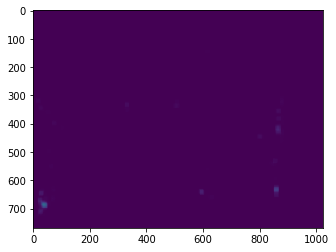

0.06084328256179106


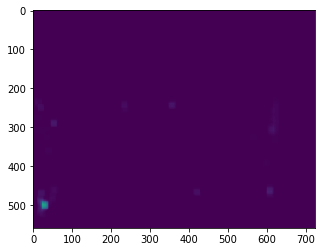

0.029066841374515207


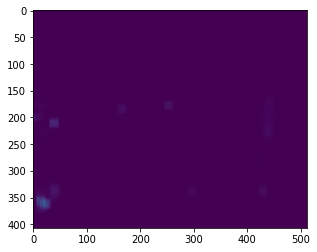

0.010759622433397453


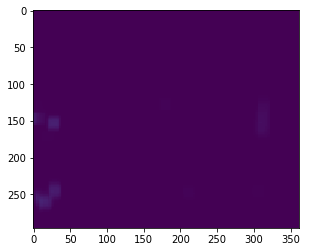

0.031654668564442545


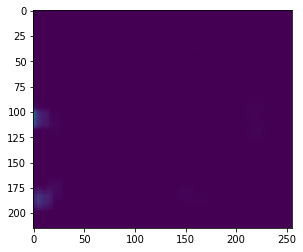

0.007821577290087589


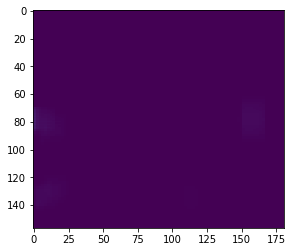

0.0018009367649938213


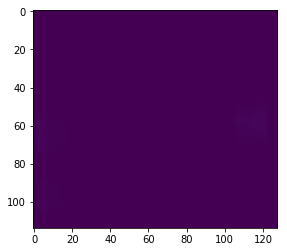

0.0007122459464881103


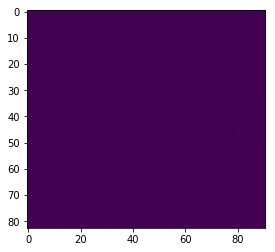

0.0004532086118160805


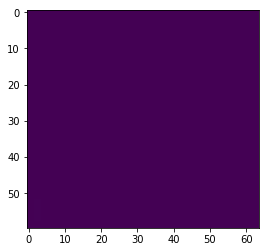

0.0006015003988674531


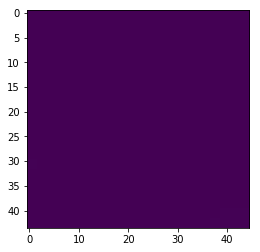

0.00039557227263458116


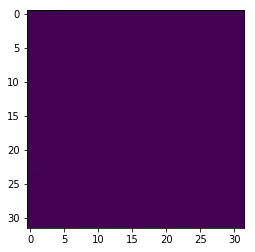

Result for 02_pass_number_vertical.pickle is 0.568 gini
0.03404436646552256


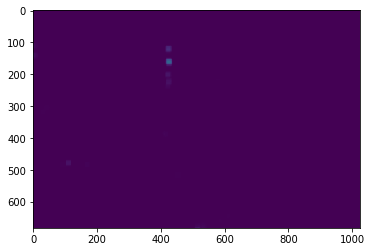

0.02328649276881345


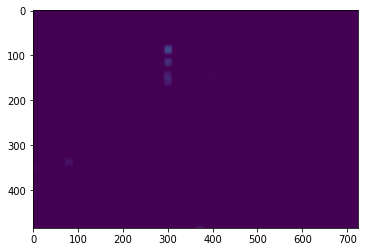

0.01737846655305475


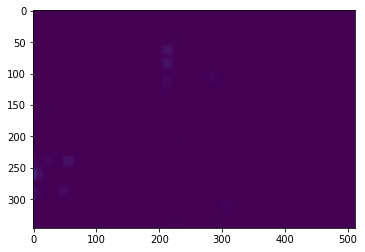

0.017505841969978064


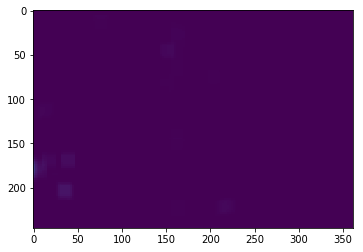

0.002642749166085423


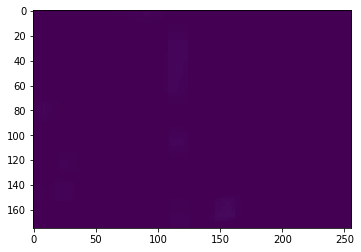

0.005072088565547972


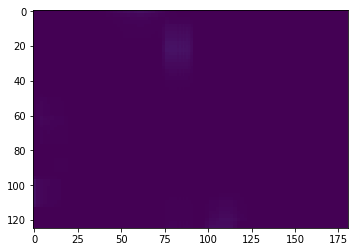

0.005564096642446836


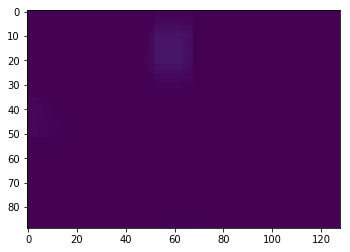

0.0016721780832359423


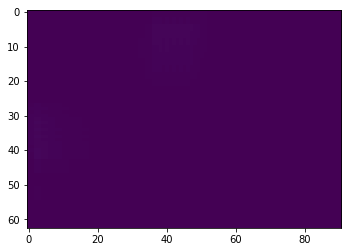

0.001620340872250381


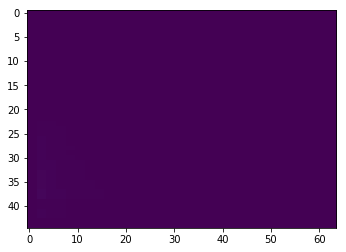

0.00021285394177539274


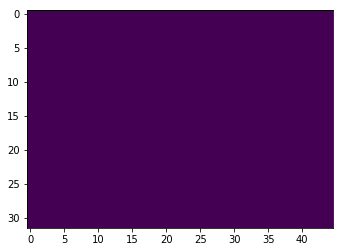

Result for 03_pass_number_vertical.pickle is 0.631 gini
0.11576058343280238


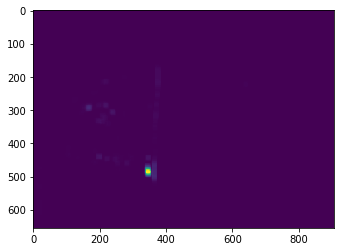

0.044407285711741906


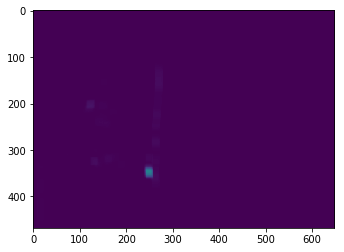

0.04705662845481129


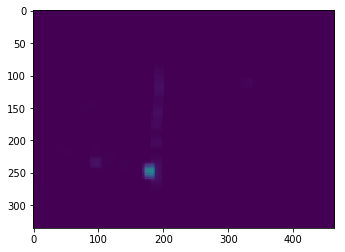

0.008633935169228835


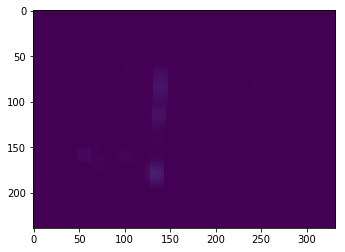

0.0043729297141561485


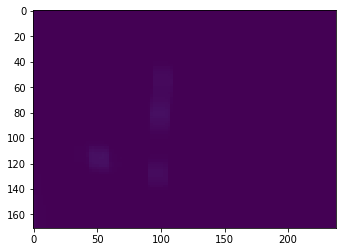

0.003693017348023938


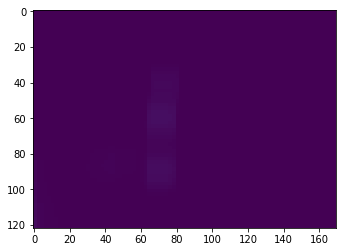

0.0031175253196320807


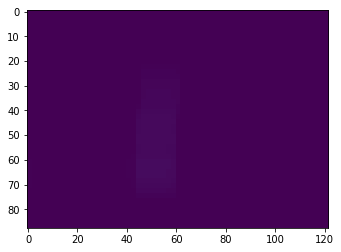

0.00303391607660064


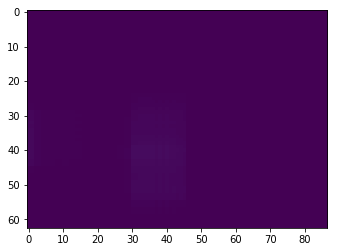

0.002036763461821023


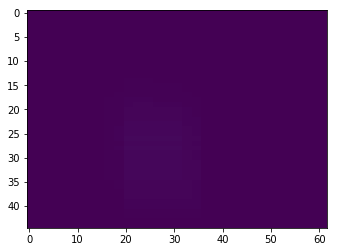

0.001480243809477999


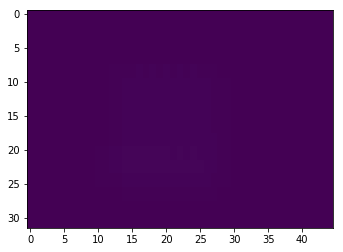

Result for 04_pass_number_vertical.pickle is 0.839 gini
0.010519149055609467


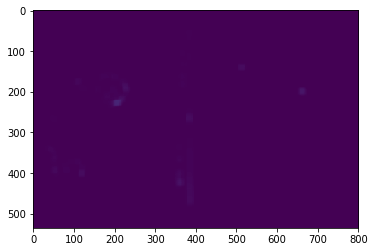

0.02638980833887672


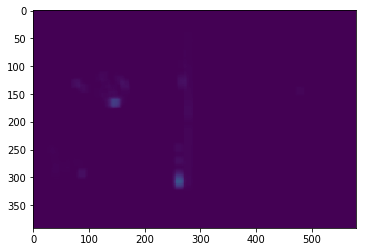

0.01014356724863319


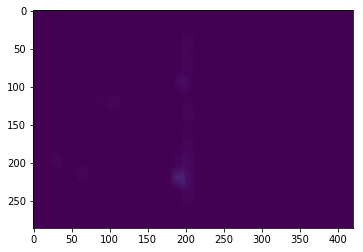

0.00784266580012627


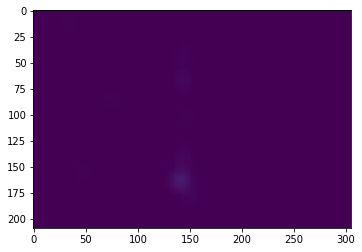

0.0013295906913413091


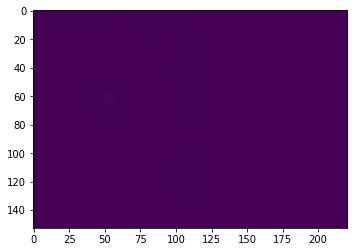

0.002455388595990371


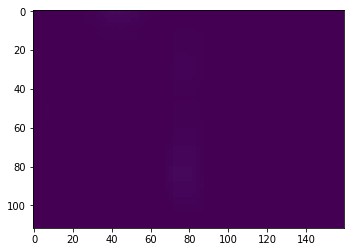

0.010348801342293731


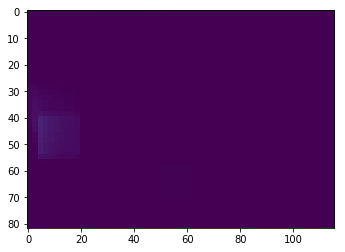

0.003939251246634967


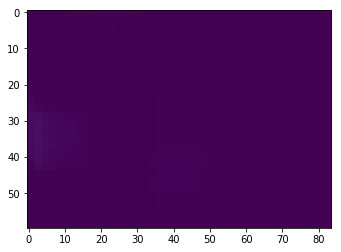

0.004259564874363815


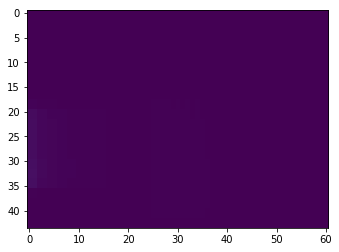

0.0003274634743644829


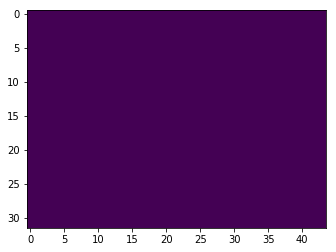

KeyboardInterrupt: 

In [14]:
calc_names = ['01_pass_number_vertical.pickle', '02_pass_number_vertical.pickle', '03_pass_number_vertical.pickle',
              '04_pass_number_vertical.pickle', '05_pass_number_vertical.pickle', '06_pass_number_vertical.pickle',
             '08_pass_number_vertical.pickle', '08b_pass_number_vertical.pickle', 'test_vs_pass_number_vertical.pickle']
calc_batch_size = 16384
tf_saver = tf.train.Saver(max_to_keep=2)

with tf.Session() as tfs:
    tf_saver.restore(tfs, '../pass_number_model_19')
    for fname in calc_names:
        result_p = score_file(path, fname, calc_batch_size, lambda x: tf_p.eval(feed_dict={tf_input: x / 255.0 - 0.5})[:,0])
        pmaps, gini = combine_prediction(path, fname, result_p)
        print('Result for {0} is {1:.3f} gini'.format(fname, gini))
        for pmap in pmaps:
            print(np.max(pmap))
            plt.imshow(pmap.transpose(), vmin=0, vmax=0.1)
            plt.show()

In [65]:
sklearn.metrics.roc_auc_score(full_y>0.5, full_p)*2-1

0.9805319656469242

In [60]:
full_y.mean()
full_p.mean()

0.038236156